In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the fashion mnist dataset
fashion_data = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Normalizing the data
fashion_scaled_train = fashion_data[0][0] / 255
fashion_scaled_test = fashion_data[1][0] / 255

# 

# Splitting up the dat into train, valid, test
fashion_train = tf.data.Dataset.from_tensor_slices((fashion_scaled_train[:40000], fashion_data[0][1][:40000]))
fashion_test = tf.data.Dataset.from_tensor_slices((fashion_scaled_test, fashion_data[1][1]))
fashion_valid = tf.data.Dataset.from_tensor_slices((fashion_scaled_train[40000:], fashion_data[0][1][40000:]))

# Shuffling the dataset
fashion_train = fashion_train.shuffle(1000)
fashion_test = fashion_test.shuffle(1000)
fashion_valid = fashion_valid.shuffle(1000)

In [4]:
# Sanity Check because aurelien is a dolt
for something in fashion_test:
    print(something)
    break

(<tf.Tensor: shape=(28, 28), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.22745098,
        0.67843137, 0.35686275, 0.16078431, 0.0627451 , 0.15294118,
        0.48627451, 0.63921569, 0.        , 0.        , 0.01176471,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.        , 0.01960784, 0.89019608,
        0.93333333, 0.97254902, 1.        , 1.        , 1.        ,
        0.90588235, 0.96862745, 0.60392157, 0.        , 0.02745098,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02352941, 0.        , 0.12156863, 0.98039216,
        0.51764706, 0.68235294, 0.83529412,

In [5]:
# Loading the Protobuf format and making the Example object function
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                # I tried to use just image as a float32 numpy array but it does not work with FloatList
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))
    

In [6]:
# Sanity Check for the protobuf creator
for image, label in fashion_train.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\002\022\010\022\002\010\034\022\002\010\034\"\2001\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\0

In [7]:
# Creating function that splits each dataset into ten files and write to them in one at a time
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    
    # Getting a list of uniquely named paths for the data set
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    
    # The exit stack will ensure that the writers will auto-exit on the case that they are not closed manually
    with ExitStack() as stack:
        
        # Getting a list of active writers for each of the ten files
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        
        # Using enumerate to cleverly get each of the names of the file paths defined earlier
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths


In [8]:
# Loading each of the datasets to their respective ten file paths 
train_filepaths = write_tfrecords("my_fashion_mnist.train", fashion_train)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", fashion_valid)
test_filepaths = write_tfrecords("my_fashion_mnist.test", fashion_test)

In [9]:
# Now unloading the tfrecords formatted files
def preprocess(tfrecord):
    
    # Setting up the landing pad of upcoming read protobufs
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parsing a single example protobuf from the file
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    
    # Getting the image portion of the protobuf
    image = tf.io.parse_tensor(example["image"], out_type=tf.double)
    
    # Reshaping the image
    image = tf.reshape(image, shape=[28, 28])
    
    # Returning the image and the label portion of the protobuf. The label portion is already saved as a int_64
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    # When a TFRecordDataset is read, it is a dataset that is still unparsed and in it's TFRecord form, just collected
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    
    # Caching the files from each of the filepaths
    if cache:
        dataset = dataset.cache()
        
    # Loading the shuffle buffer size
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    # Using the preprocess function to map(parse) the unparsed data into the instance (image, label)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    # Prefetch for faster processing one batch ahead
    return dataset.prefetch(1)

In [10]:
# Using the two functions above to load efficient datasets (unparsed) and then constructing the dataset
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=40000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)
# Instead of having an numpy array of instances, the tfrecords files are read and constructed into an instance
# on the fly

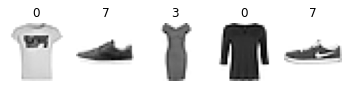

In [61]:
# Sanity check to make sure the images are still intact
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [63]:
# I think the clear_session() clears the memory from the cache and loaded TFRecords protobufs.
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# I think this does the same thing as these (IT DOESN'T READ THE DIFFERENCES BELOW)

#### NONONO this does LAYER normalization! As in each layer(r,g,b) in the instance is normalized one at a time
# Layer Normalization
# - Each Channel is normalized individually, one instance at a time. So a single rgb image will have an r mean
# and std-dev, g mean and std-dev, and b mean and std-dev
#
# Batch Normalization
# - All of the red channels in a batch have a single mean and std-dev, all of the green channels have a single mean
# and std-dev, and all the blue channels in a batch have a single mean and std-dev
#
# Instance Normalization
# - Each instance has only one mean and std-dev for the whole instance

class LayerNorm(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        # The first shape would be the batch size
        self.units = tf.constant(100.)
        self.kernel = self.add_weight(name="kernel", shape=batch_input_shape[-1:], initializer="ones")
        self.bias = self.add_weight(name="bias", shape=batch_input_shape[-1:], initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        self.mean, self.variance = tf.nn.moments(inputs, axes=-1,keepdims=True)
        self.epsilon = 3e-4
        self.std_dev = tf.math.sqrt(self.variance)
        # Matrix multiplication MUST be between 2-dimensional matrices
        return (((inputs - self.mean) * (self.kernel))/(self.std_dev + self.epsilon)) + self.bias

# Keras version of the LayerNormalization
keras_layer_norm = tf.keras.layers.LayerNormalization()

In [65]:
# Batch Standardization layer
class Standardization(tf.keras.layers.Layer):
    def adapt(self, data_sample):
        # axis = 0 because we are normalizing along the batch. All the red channels will have a single mean and std...
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + tf.keras.backend.epsilon())

# You must instantiate the layer and then put in the input shape
standardization = Standardization(input_shape=[28, 28])

# Then making a small batch for generating the mean and standard deviation for the layer
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [69]:
# This function also works if you fit the model with 
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# callbacks=[tensorboard_cb]

# Setting up Tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'
# This will allow for the tensorboard to track the current metrics in a time-based file in a specific library

In [72]:
# Setting up Tensorboard Way 2
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs", "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

In [73]:
# Setting the tensorflow callback into two different
# Way 1 
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
# Way 2 
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)

In [74]:
# Making a dummy model just to test the functionality
model = tf.keras.models.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [75]:
model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5
1250/1250 [==============================] - 2s 1ms/step - loss: 0.4819 - accuracy: 0.8361 - val_loss: 0.3897 - val_accuracy: 0.8651
Epoch 2/5
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3481 - accuracy: 0.8756 - val_loss: 0.3816 - val_accuracy: 0.8640
Epoch 3/5
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3033 - accuracy: 0.8901 - val_loss: 0.3505 - val_accuracy: 0.8795
Epoch 4/5
1250/1250 [==============================] - 2s 1ms/step - loss: 0.2756 - accuracy: 0.9004 - val_loss: 0.3594 - val_accuracy: 0.8750
Epoch 5/5
1250/1250 [==============================] - 2s 1ms/step - loss: 0.2514 - accuracy: 0.9084 - val_loss: 0.3603 - val_accuracy: 0.8797


In [77]:
# Type this into the terminal to display the 
# tensorboard --logdir= ./'Chapter 13 Exercises'/my_logs --port=6006

SyntaxError: invalid syntax (<ipython-input-77-b79fbadb2455>, line 1)